# Exploratory Data Analysis on E-commerce Dataset with Multi-dimensional Features

This project uses the public e-commerce dataset from Brazil's Olist platform. The data includes the complete process of users from registration, order placement, product browsing, order completion to rating. Based on this dataset, an integrated learning model for user rating prediction is constructed.

# Introduction to User Rating Prediction Task
In today's increasingly digitalized shopping era, users' shopping experiences and satisfaction levels on e-commerce platforms are often reflected through rating systems. Behind a simple rating lies users' genuine feedback on multiple aspects such as product quality, logistics speed, and after-sales service. For platforms, accurately predicting user ratings not only helps identify problematic aspects of services but also enables proactive optimization of the user experience before potential negative reviews occur.

Compared with traditional order prediction, rating prediction is more complex. Some users are extremely picky about products and give low scores for slight dissatisfaction; some users are price-sensitive, and low cost-effectiveness may lead to negative reviews; there are also users whose rating behavior changes over time, with significant fluctuations around holidays.

Such behavioral differences make it difficult for platforms to determine whether a particular order will receive positive or negative reviews based solely on product attributes or historical average ratings.

If the platform can intelligently predict user ratings for orders based on multi-dimensional data such as users' past behaviors, product characteristics, logistics information, order placement and delivery times, it can bring value in multiple aspects:

- Intervene in bad review risks in advance: The system can trigger manual services or preferential retention in advance for orders with low expected ratings;

- Optimize the product recommendation mechanism: Prioritize recommending products that users are more likely to rate highly.

- Assist merchants in operational analysis: Identify key factors affecting ratings, such as slow logistics, discrepancies between product descriptions and actual items, etc.

- Improve overall user satisfaction: Achieve data-driven service improvement through a closed loop of prediction and optimization.

Traditional rating analysis often relies on average scores or rule-based settings, but it ignores the individual differences in rating behaviors and their contextual dependencies. By leveraging machine learning and big data mining methods, we can integrate information such as order details, user profiles, product attributes, and temporal features to build more interpretable and generalized rating prediction models. These models provide strong support for the platform's personalized services and refined operations.


## Standard package imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## Standard functions utilized throughout the notebook

In [30]:
#Plot a bar chart
def plot_chart(data, title, x_label, y_label):
    # Set image clarity
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.family'] = 'SimHei'  
    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

#Plot a time-series chart
def plot_time_series(data, title, x_label, y_labels, colors=None, figsize=(10, 6)):
    # Set image clarity
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.family'] = 'SimHei'  
    
    # Create a chart
    fig, ax1 = plt.subplots(figsize=figsize)
    # First line chart
    color = colors[0] if colors else 'tab:blue'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_labels[0], color=color)
    ax1.plot(data.index.astype(str), data[y_labels[0]], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Follow-up line chart (if any)
    axes = [ax1]
    for i, y_label in enumerate(y_labels[1:]):
        color = colors[i+1] if colors and len(colors) > i+1 else f'tab:{i+1}'
        ax = ax1.twinx()
        ax.set_ylabel(y_label, color=color)
        ax.plot(data.index.astype(str), data[y_label], color=color)
        ax.tick_params(axis='y', labelcolor=color)
        axes.append(ax)
    
    #Adjust layout
    plt.title(title)
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()
    
    return fig, axes

#Draw a heatmap
def plot_heatmap(data, title='Correlation Between Order Volume and Time Features',
                           figsize=(10, 8), cmap='coolwarm', annot=True):
    plt.figure(figsize=figsize)
    sns.set(style="white")  
    heatmap = sns.heatmap(
        data,
        annot=annot,
        fmt=".2f",
        cmap='coolwarm',     
        center=0,
        square=True,
        linewidths=0.8,
        linecolor='lightgrey',
        cbar_kws={"shrink": 0.8, "aspect": 30}
    )
    # Beautify title and labels
    plt.title(title, fontsize=16, weight='bold', pad=15)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    # Remove redundant borders
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

#Plot a pie chart
def plot_pie_chart(series, title="Category Distribution", figsize=(8, 8)):
    # Set image resolution and font
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.family'] = 'SimHei'  # Change if needed

    # Compute counts and percentages
    value_counts = series.value_counts()
    percentages = value_counts / len(series) * 100

    # Plot pie chart
    plt.figure(figsize=figsize)
    plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Keep pie chart circular
    plt.show()

    return {'Category Counts': value_counts, 'Percentage (%)': percentages}

# Data Description
There are 4 CSV files with the following contents:

- Order Details Table (olist_order_items_dataset.csv): Lists the product details of each order, including product ID, seller ID, price, freight, etc. It is a key data table for calculating order amounts and consumption preferences.
- Order Information Table (olist_orders_dataset.csv): Describes the order lifecycle from September 2016 to October 2018, including order placement time, shipment time, delivery time, and order status.
- Product Information Table (olist_products_dataset.csv): Provides product attribute information such as category names, dimensions, and weight, which can be used to analyze user purchase preferences and the relationship between product characteristics and order amounts.
- Review Information Table (olist_order_reviews_dataset.csv): Contains user ratings (1 to 5 stars) for orders, serving as the core table for classifying product ratings.

In [4]:
#Read 4 data files
order_items = pd.read_csv(r"D:\桌面\project\data\olist_order_items_dataset.csv")
order_reviews = pd.read_csv(r"D:\桌面\project\data\olist_order_reviews_dataset.csv")
orders = pd.read_csv(r"D:\桌面\project\data\olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
products = pd.read_csv(r"D:\桌面\project\data\olist_products_dataset.csv")

#Sort order data by order placement time
orders_sorted = orders.sort_values(by="order_purchase_timestamp", ascending=True)

## Order Detail Data Processing
### List the product details included in each order
<pre>
    - order_id 
    - customer_id, 
    - order_purchase_timestamp, 
    - order_delivered_customer_date
    - order_status
</pre>

In [32]:
print(f"Shape of the Order Records: {order_items.shape}")
print("\n")
order_items.head()

Shape of the Order Records: (112650, 11)




,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,year_month,month,weekday,price_freight_ratio
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09,9,1,4.431903
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-05,5,2,12.037129
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01,1,3,11.135981
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08,8,2,1.015637
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02,2,0,11.019845


## Key Metric Statistics

In [33]:
# Calculate the number of orders, products, and sellers
num_orders = order_items['order_id'].nunique()
num_products = order_items['product_id'].nunique()
num_sellers = order_items['seller_id'].nunique()

# Calculate descriptive statistics for price and freight value, rounded to two decimal places
price_stats = order_items['price'].describe().round(2)
freight_stats = order_items['freight_value'].describe().round(2)

print('Number of Orders:', num_orders)
print('Number of Products:', num_products)
print('Number of Sellers:', num_sellers)
print('Descriptive Statistics of Price:\n', price_stats)
print('Descriptive Statistics of Freight Value:\n', freight_stats)

Number of Orders: 98666
Number of Products: 32951
Number of Sellers: 3095
Descriptive Statistics of Price:
 count    112650.00
mean        120.65
std         183.63
min           0.85
25%          39.90
50%          74.99
75%         134.90
max        6735.00
Name: price, dtype: float64
Descriptive Statistics of Freight Value:
 count    112650.00
mean         19.99
std          15.81
min           0.00
25%          13.08
50%          16.26
75%          21.15
max         409.68
Name: freight_value, dtype: float64


## Missing value and duplicate value detection

In [34]:
# Check for missing values
missing_values = order_items.isnull().sum()

# Check for duplicate rows
duplicate_rows = order_items.duplicated().sum()

print('Number of missing values in each column:')
print(missing_values)
print('Number of duplicate rows in the dataset:', duplicate_rows)

Number of missing values in each column:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
year_month             0
month                  0
weekday                0
price_freight_ratio    0
dtype: int64
Number of duplicate rows in the dataset: 0


This data has no missing or duplicate values

## Add time features

In [35]:
order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"])
order_items["year_month"] = order_items["shipping_limit_date"].dt.to_period("M").astype(str)
order_items["month"] = order_items["shipping_limit_date"].dt.month
order_items["weekday"] = order_items["shipping_limit_date"].dt.weekday  # 0=Monday


### Outlier analysis
Remove outliers / Cleanse abnormal data

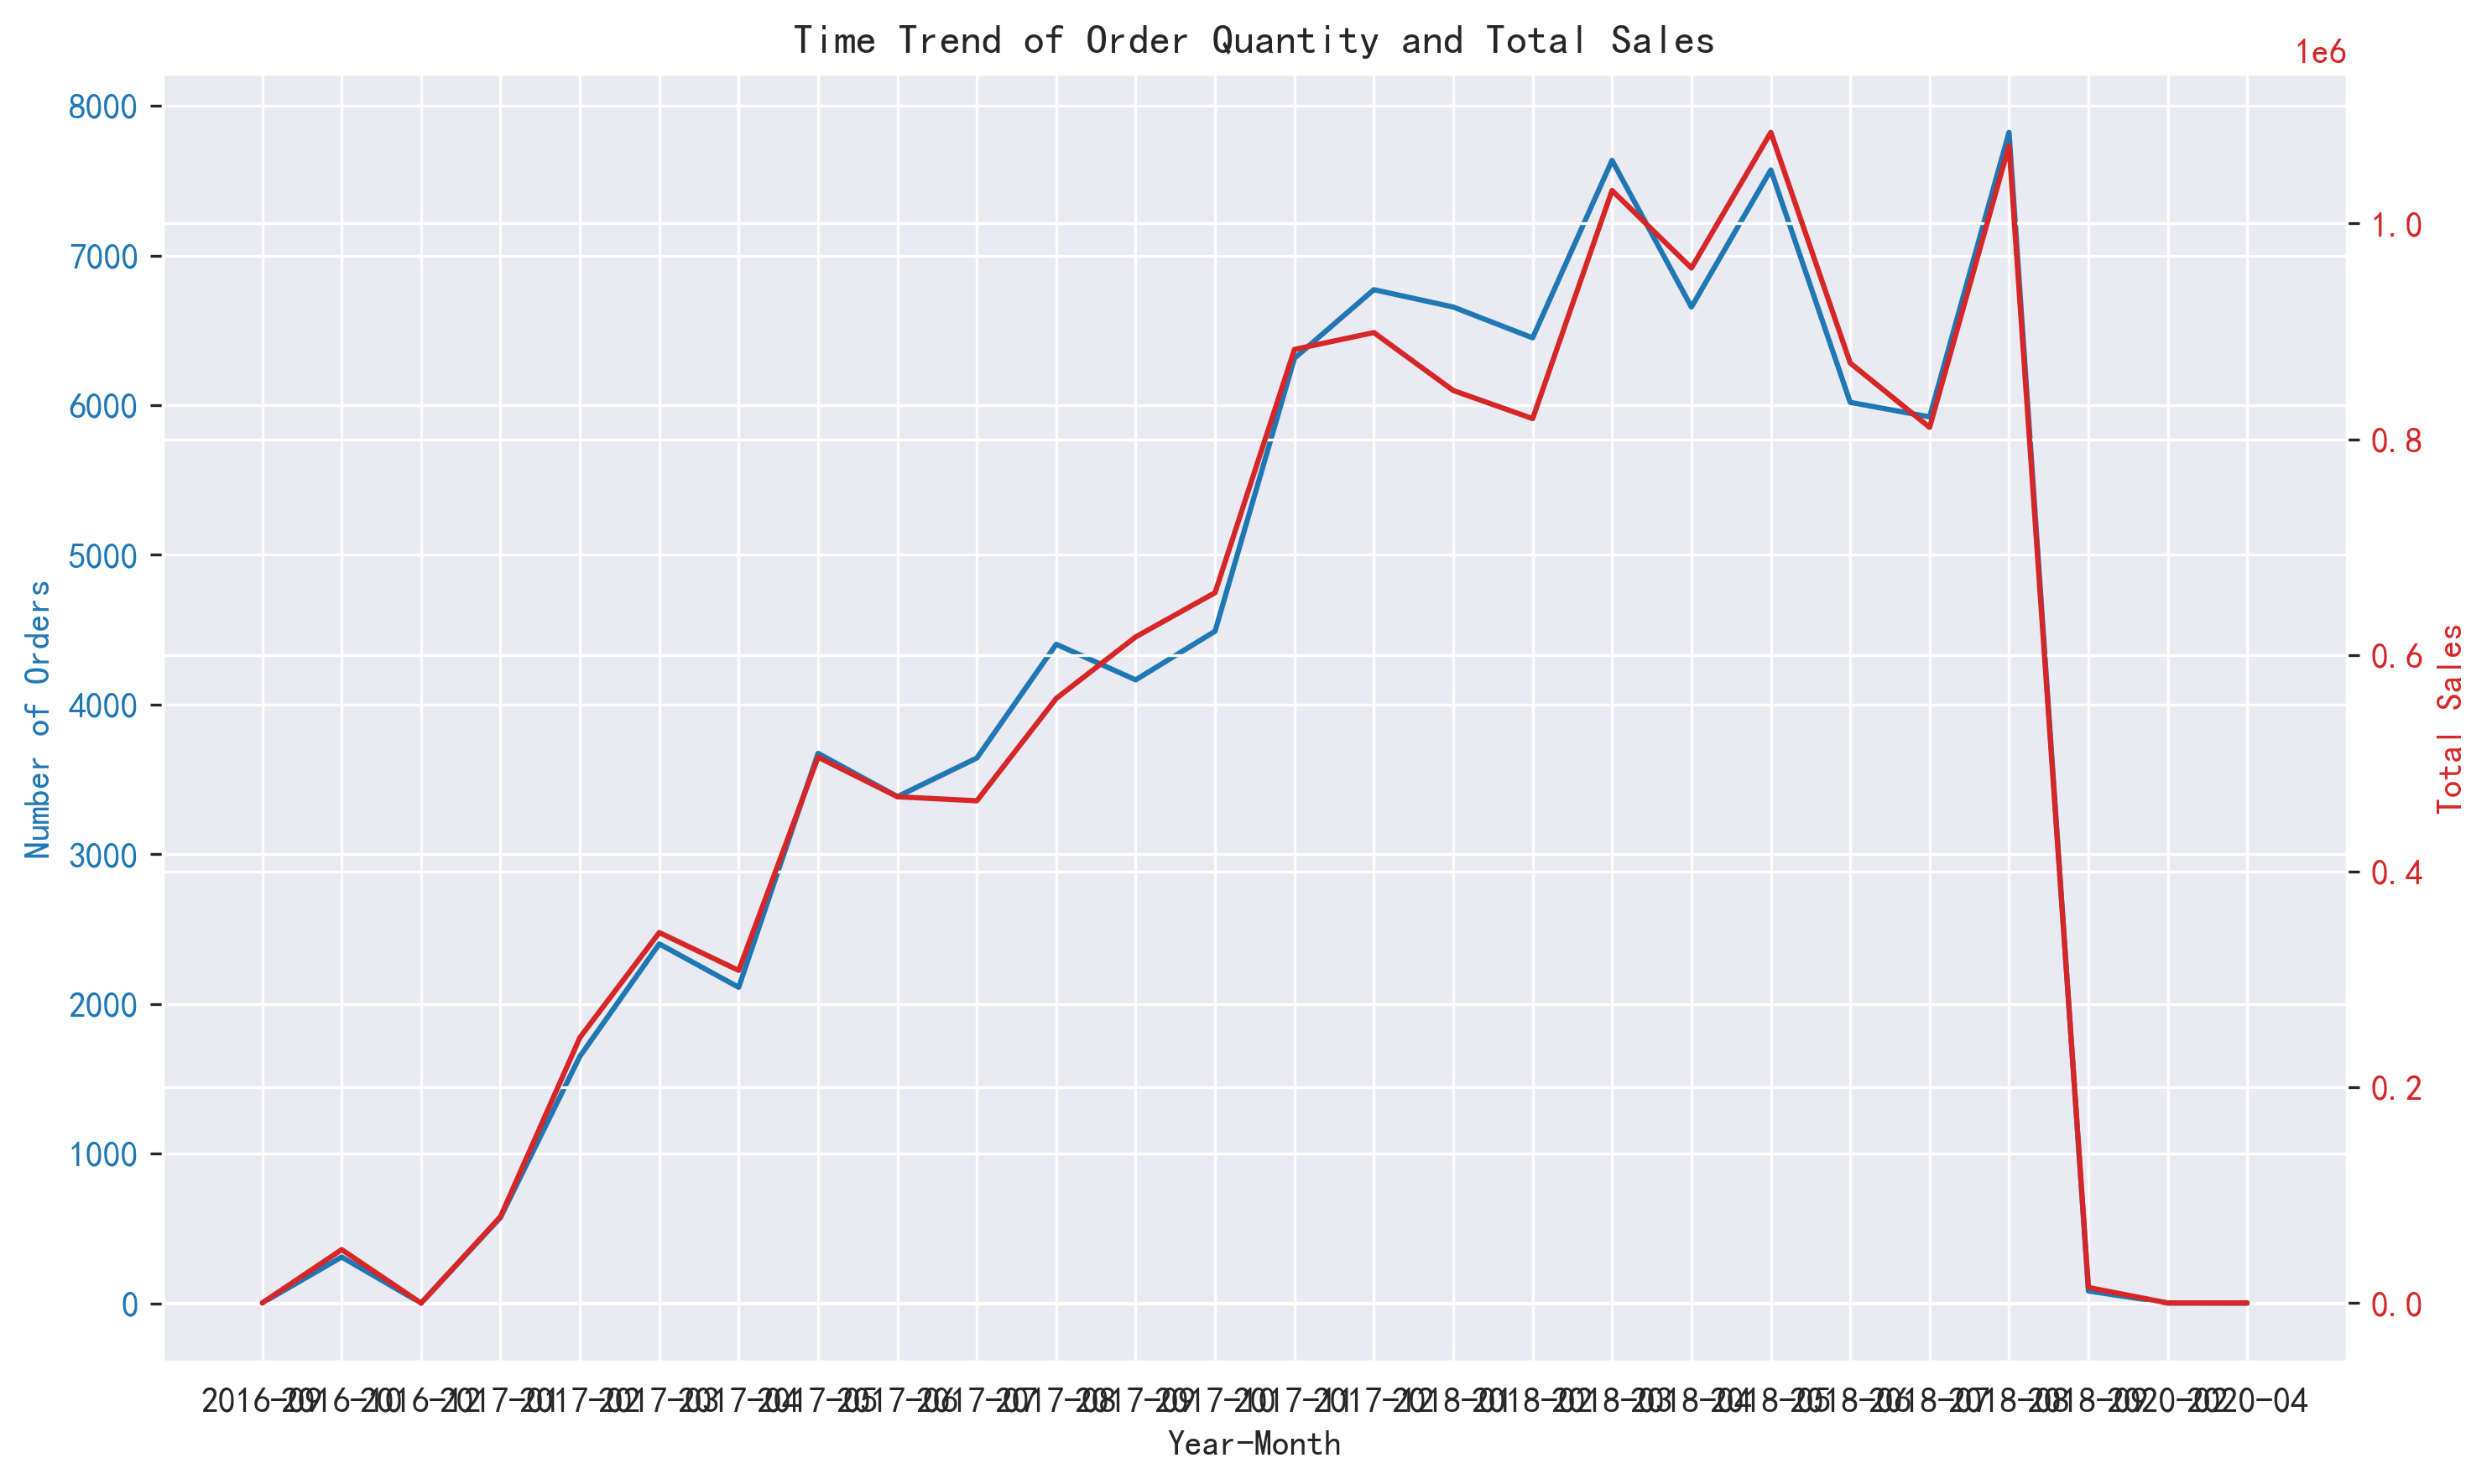

Monthly Order Quantity and Total Sales:
             Number of Orders  Total Sales
year_month                               
2016-09                    2       194.47
2016-10                  309     49580.55
2016-12                    1        10.90
2017-01                  573     80124.74
2017-02                 1650    245982.01
2017-03                 2401    343242.60
2017-04                 2111    308148.32
2017-05                 3674    505655.46
2017-06                 3385    469001.05
2017-07                 3643    465282.10
2017-08                 4403    560093.34
2017-09                 4165    617046.12
2017-10                 4490    658020.23
2017-11                 6314    883351.63
2017-12                 6772    898920.98
2018-01                 6656    845279.18
2018-02                 6450    819228.85
2018-03                 7636   1030527.84
2018-04                 6656    958729.70
2018-05                 7572   1084358.55
2018-06                 6019    870

In [36]:
# Plot time trends for order quantity and total sales
# Data preparation section
monthly_orders = order_items.groupby('year_month').agg({'order_id': 'nunique', 'price': 'sum'}).rename(
    columns={'order_id': 'Number of Orders', 'price': 'Total Sales'})

# Call function to plot line chart
plot_time_series(
    data=monthly_orders,
    title='Time Trend of Order Quantity and Total Sales',
    x_label='Year-Month',
    y_labels=['Number of Orders', 'Total Sales'],
    colors=['tab:blue', 'tab:red']
)

print('Monthly Order Quantity and Total Sales:\n', monthly_orders)

From January 2017 to August 2018 is the main time period of the data, covering a complete sales cycle of 20 months. The data volumes from September to December 2016, September 2018, and February and April 2020 are too small, making them abnormal time periods. Data records from these time points should be excluded to avoid interference.


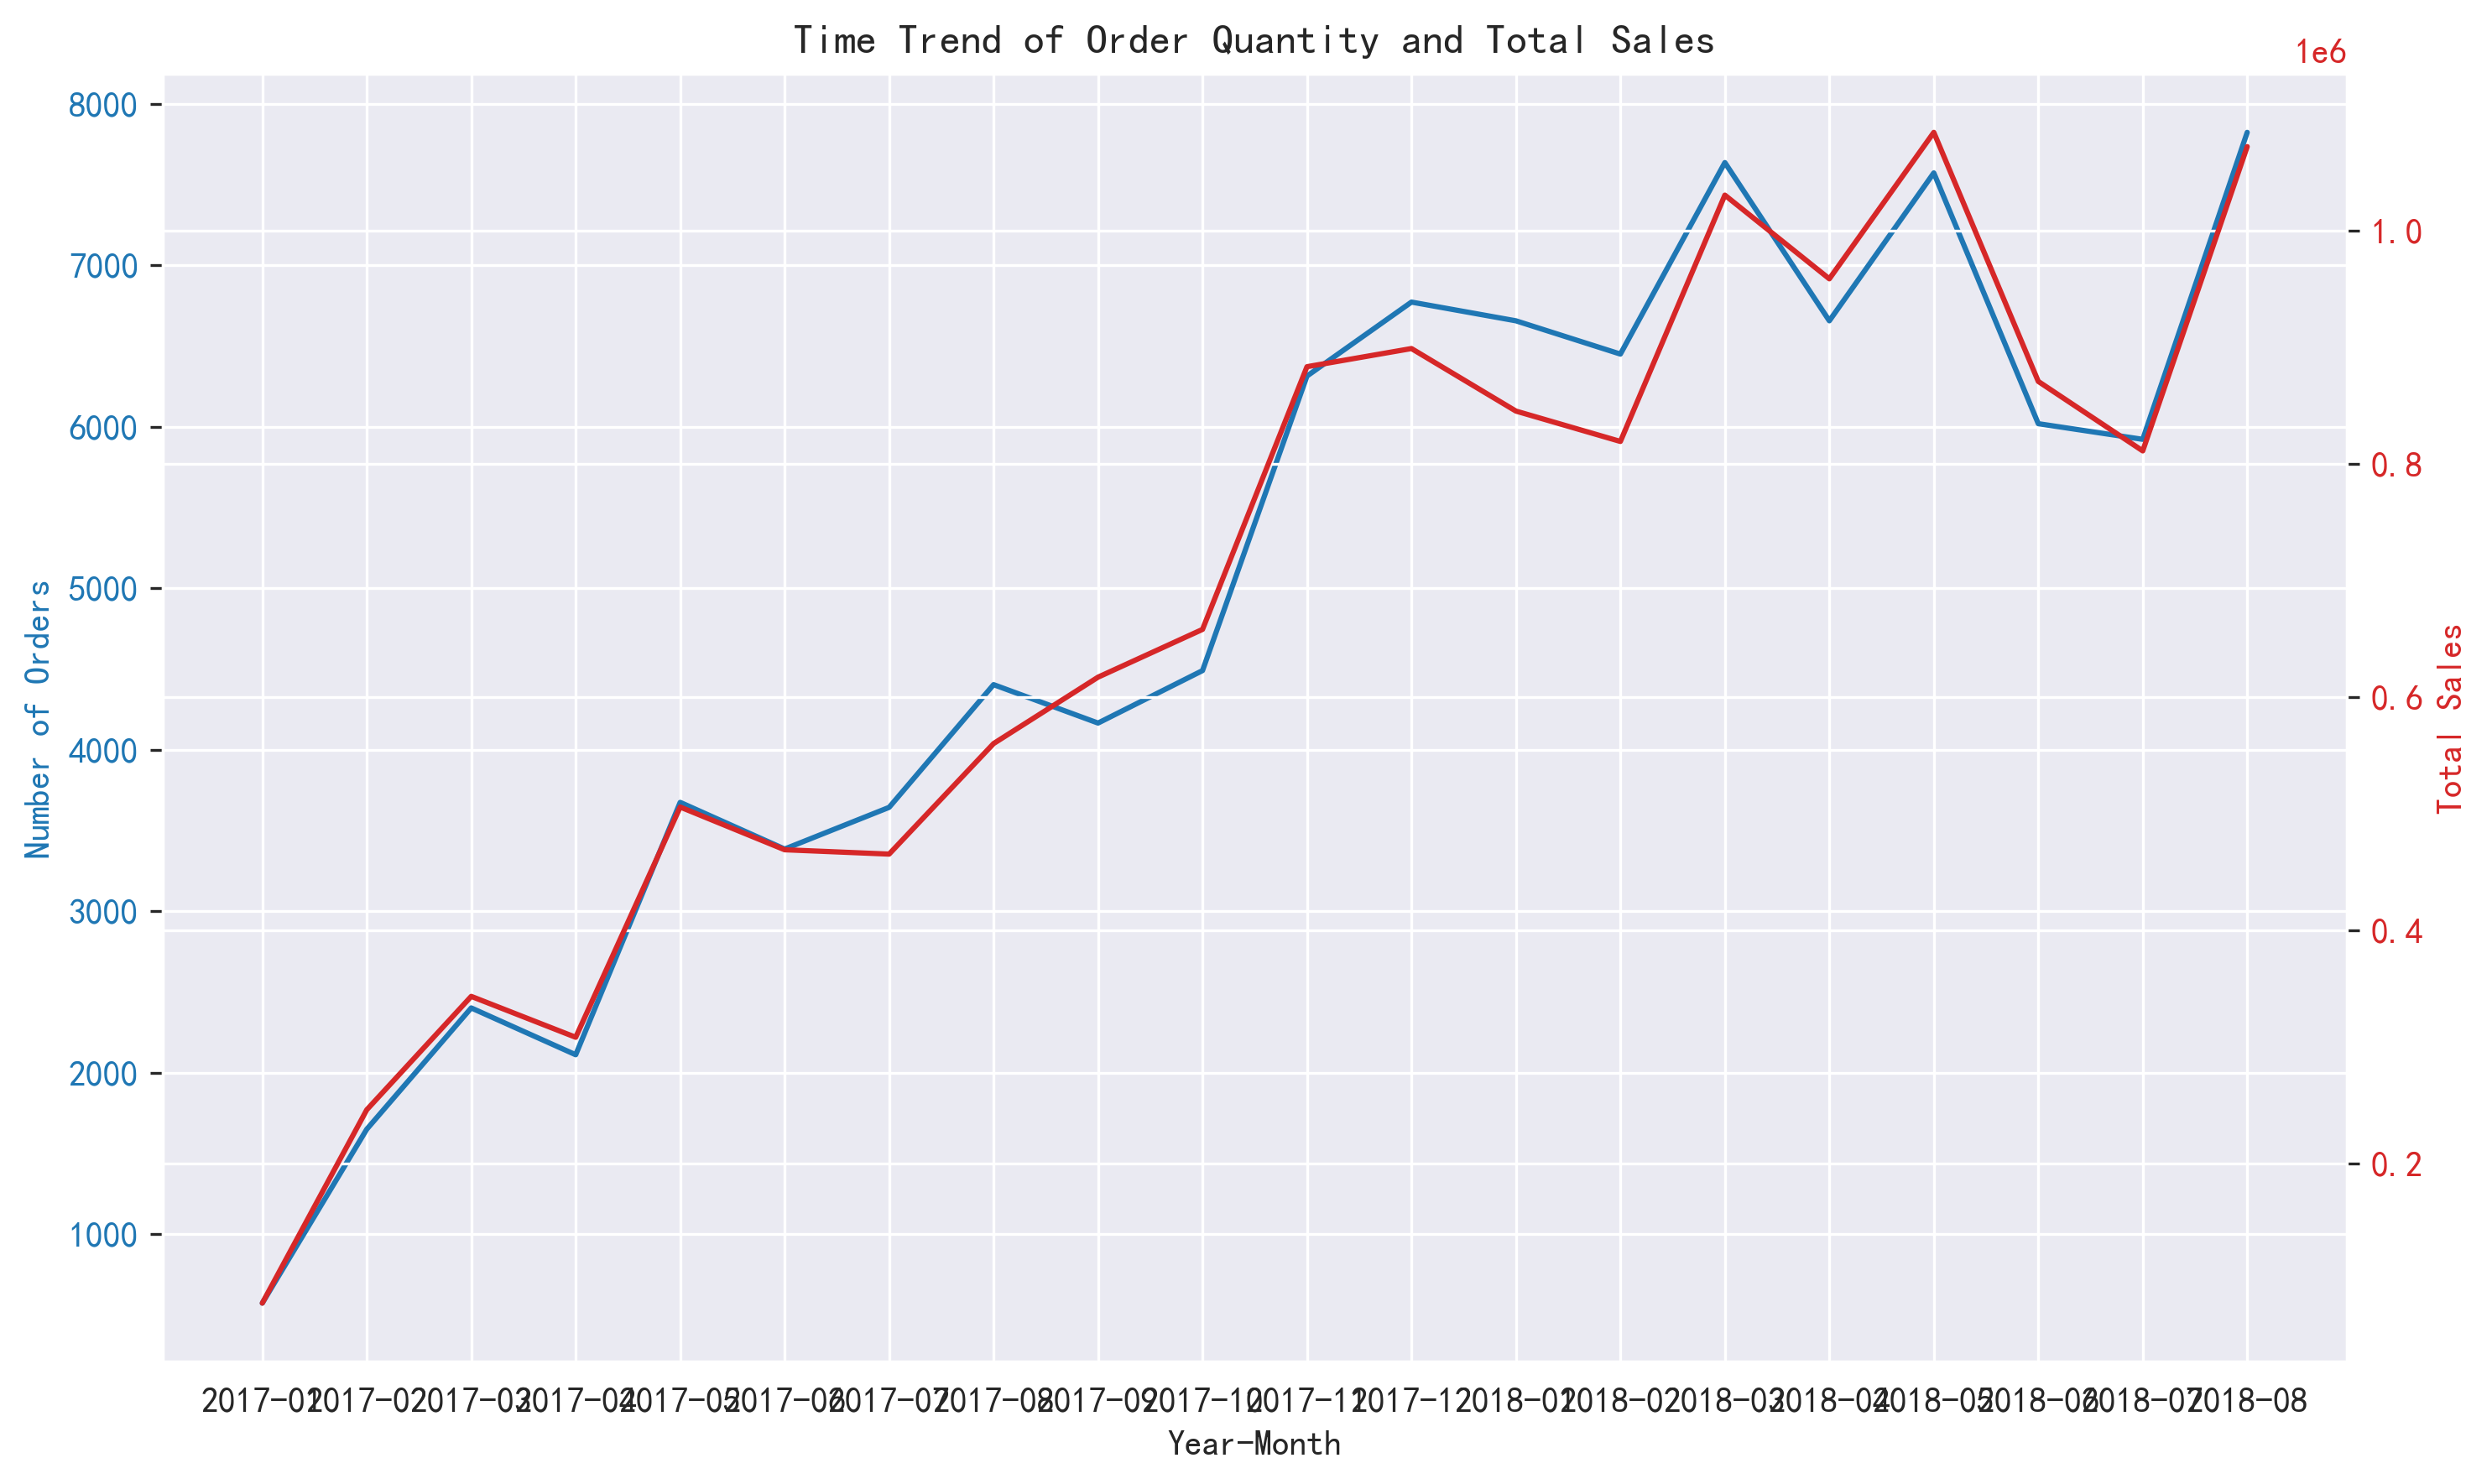

(<Figure size 3000x1800 with 2 Axes>,
 [<Axes: xlabel='Year-Month', ylabel='Number of Orders'>,
  <Axes: title={'center': 'Time Trend of Order Quantity and Total Sales'}, ylabel='Total Sales'>])

In [37]:
# Define abnormal time periods to be excluded
anomalous_months = ['2016-09', '2016-10','2016-12', '2018-09', '2020-02', '2020-04']

# Execute data exclusion
order_items_clean = order_items[~order_items['year_month'].isin(anomalous_months)].copy()
monthly_orders2 = order_items_clean.groupby('year_month').agg({'order_id': 'nunique', 'price': 'sum'}).rename(
    columns={'order_id': 'Number of Orders', 'price': 'Total Sales'})

# Call function to plot line chart
plot_time_series(
    data=monthly_orders2,
    title='Time Trend of Order Quantity and Total Sales',
    x_label='Year-Month',
    y_labels=['Number of Orders', 'Total Sales'],
    colors=['tab:blue', 'tab:red']
)


From the beginning of 2017 to the middle of 2018, both the order volume and sales amount showed a basically year-on-year growth trend, indicating a strong correlation between sales and the number of orders. Therefore, predicting the order trend alone can be sufficient to forecast the sales trend.

It is advisable to consider using sales amount and order volume as correlation features for user rating.

In [38]:
# Save the processed data as a CSV file
csv_path = r'D:\桌面\project\data\clean\order_items.csv'
order_items.to_csv(csv_path, index=False)

print(f'The processed data has been saved to: {csv_path}')

The processed data has been saved to: D:\桌面\project\data\clean\order_items.csv


## Observations on the Order Details Table (olist_order_items_dataset.csv)
- This dataset covers the full lifecycle of orders from September 2016 to October 2018, completely recording the order placement time, shipping time, delivery time, and order status for each order.
- The data has no missing values or duplicate rows. Each order is uniquely identified, and timestamps are arranged in order, which facilitates calculating the time spent at each stage and analyzing time-series characteristics.
- There is a strong correlation between total sales and the number of orders, indicating that freight expenditure basically grows year-on-year with the platform's transaction volume. Therefore, predicting the order trend alone can forecast the sales trend.
- It is advisable to consider using sales amount and order volume as correlated features for user ratings.
- **Data preprocessing** : Time features (including year, month, and day of the week) were added, and abnormal months with excessively low order volumes (including September-December 2016, September 2018, and February and April 2020) were excluded. Meanwhile, descriptive statistics were conducted for the number of orders, number of sellers, number of products, prices, and shipping fees.

# Order information data
### Describe the order lifecycle from September 2016 to October 2018.
<pre>
    - order_id 
    - customer_id, 
    - order_status， 
    - order_approved_at
    - order_delivered_carrier_date
    - order_delivered_customer_date
    - order_estimated_delivery_date
</pre>

## Key indicator statistics

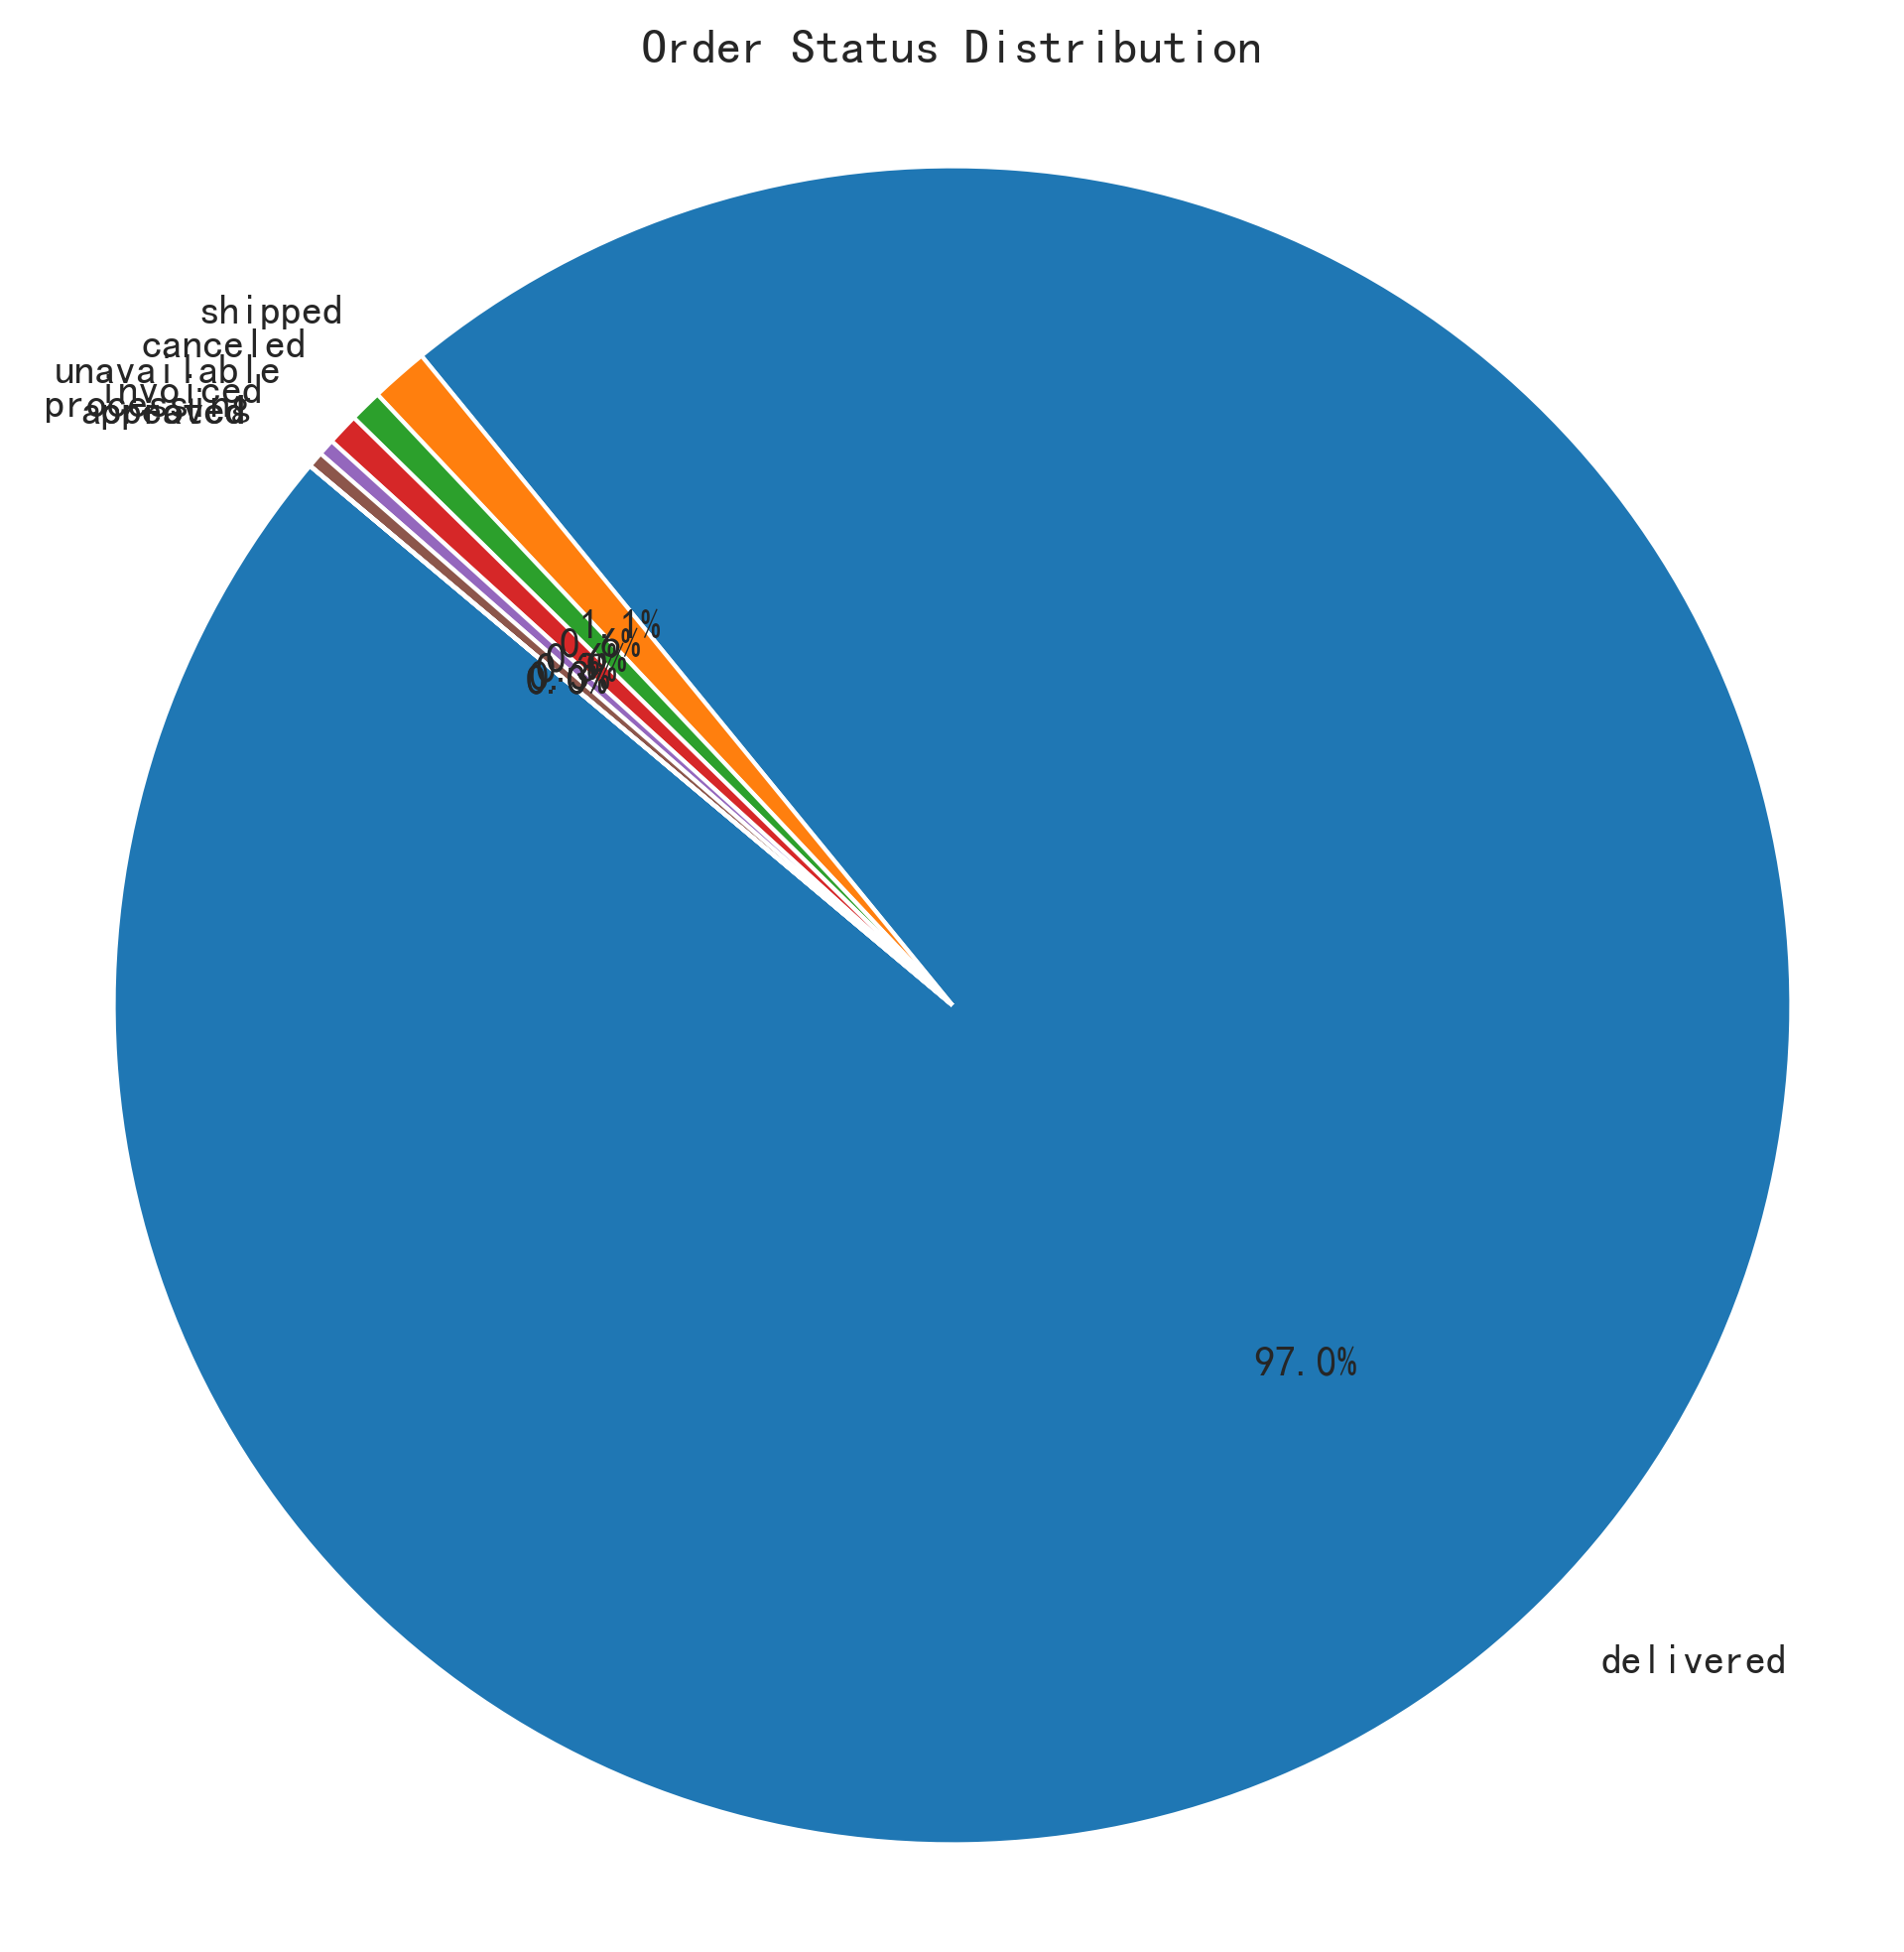

{'Category Counts': delivered      96478
 shipped         1107
 canceled         625
 unavailable      609
 invoiced         314
 processing       301
 created            5
 approved           2
 Name: order_status, dtype: int64,
 'Percentage (%)': delivered      97.020344
 shipped         1.113223
 canceled        0.628513
 unavailable     0.612423
 invoiced        0.315765
 processing      0.302692
 created         0.005028
 approved        0.002011
 Name: order_status, dtype: float64}

In [44]:
plot_pie_chart(orders_sorted['order_status'], title='Order Status Distribution')

It shows that the vast majority of orders are in the delivered status. For the remaining orders, consideration can be given to consolidating them into an "uncompleted category" or directly excluding them during product clustering prediction.


## Remove duplicate values and missing values

In [46]:
# Check for duplicate values
duplicate_rows = orders_sorted.duplicated().sum()

# Check for missing values
missing_values = orders_sorted.isnull().sum()

print('Number of duplicate values:', duplicate_rows)
print('Number of missing values in each column:\n', missing_values)

Number of duplicate values: 0
Number of missing values in each column:
 order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



Considering that orders in an undelivered status do not have an arrival time, only the number of orders with missing values in the delivered status needs to be processed.

In [50]:
# Filter the data where the order status is 'delivered'
delivered_orders = orders_sorted[orders_sorted['order_status'] == 'delivered']

# Count the number of rows with missing values
missing_value_count = delivered_orders.isnull().any(axis=1).sum()

print('The number of missing values where the order status is delivered:', missing_value_count)

The number of missing values where the order status is delivered: 23


Handle partial orders that are delivered but have missing data (undelivered orders do not have user reviews).

In [48]:
# Convert time fields to datetime
time_cols = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date'
]
for col in time_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Retain delivered orders that follow the normal process and have complete time fields
filtered_orders = orders[
    (orders['order_status'] == 'delivered') &
    orders[time_cols].notna().all(axis=1)
].copy()

In [49]:
# 检查缺失值
missing_values = filtered_orders.isnull().sum()

print('The number of missing values in each column:\n', missing_values)

The number of missing values in each column:
 order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64


## Feature Engineering

In [51]:
orders_sorted = filtered_orders
# Ensure that the time column is of datetime type
orders_sorted['order_purchase_timestamp'] = pd.to_datetime(orders_sorted['order_purchase_timestamp'])
orders_sorted['order_approved_at'] = pd.to_datetime(orders_sorted['order_approved_at'])
orders_sorted['order_delivered_carrier_date'] = pd.to_datetime(orders_sorted['order_delivered_carrier_date'])
orders_sorted['order_delivered_customer_date'] = pd.to_datetime(orders_sorted['order_delivered_customer_date'])

# Calculate the time spent at each stage (in hours)
orders_sorted['processing_time_approved'] = (
    orders_sorted['order_approved_at'] - orders_sorted['order_purchase_timestamp']
).dt.total_seconds() / 3600

orders_sorted['shipping_time'] = (
    orders_sorted['order_delivered_carrier_date'] - orders_sorted['order_approved_at']
).dt.total_seconds() / 3600

orders_sorted['delivery_time'] = (
    orders_sorted['order_delivered_customer_date'] - orders_sorted['order_delivered_carrier_date']
).dt.total_seconds() / 3600

# Fill in missing values with the mean
orders_sorted['processing_time_approved'].fillna(orders_sorted['processing_time_approved'].mean(), inplace=True)
orders_sorted['shipping_time'].fillna(orders_sorted['shipping_time'].mean(), inplace=True)
orders_sorted['delivery_time'].fillna(orders_sorted['delivery_time'].mean(), inplace=True)

## Key indicator statistics

In [52]:
# Analyze the descriptive statistics of processing time, shipping time, and delivery time (retain two decimal places)
time_analysis = orders_sorted[['processing_time_approved','shipping_time', 'delivery_time']].describe().round(2)
time_analysis

,processing_time_approved,shipping_time,delivery_time
count,96455.00,96455.00,96455.00
mean,10.28,67.18,223.93
std,20.54,84.89,210.25
min,0.00,-4109.26,-386.31
25%,0.22,20.98,98.39
50%,0.34,43.58,170.39
75%,14.52,85.80,288.70
max,741.44,3018.30,4924.58


There can be no negative values for time. These are erroneous entries and need to be processed.

### Outlier handling

In [53]:
# Filter out abnormal orders with negative time differences
negative_shipping = orders_sorted[(orders_sorted['order_status'] == 'delivered') & (orders_sorted['shipping_time'] < 0)]
negative_delivery = orders_sorted[(orders_sorted['order_status'] == 'delivered') & (orders_sorted['delivery_time'] < 0)]

# Merge all abnormal orders and remove duplicates
negative_time_orders = pd.concat([negative_shipping, negative_delivery]).drop_duplicates()

negative_time_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,processing_time_approved,shipping_time,delivery_time
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,124.463889,-32.617222,240.675556
64,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,delivered,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15 00:00:00,57.619167,-23.102222,24.212222
199,58d4c4747ee059eeeb865b349b41f53a,1755fad7863475346bc6c3773fe055d3,delivered,2018-07-21 12:49:32,2018-07-26 23:31:53,2018-07-24 12:57:00,2018-07-25 23:58:19,2018-07-31 00:00:00,130.705833,-58.581389,35.021944
210,412fccb2b44a99b36714bca3fef8ad7b,c6865c523687cb3f235aa599afef1710,delivered,2018-07-22 22:30:05,2018-07-23 12:31:53,2018-07-23 12:24:00,2018-07-24 19:26:42,2018-07-31 00:00:00,14.030000,-0.131389,31.045000
415,56a4ac10a4a8f2ba7693523bb439eede,78438ba6ace7d2cb023dbbc81b083562,delivered,2018-07-22 13:04:47,2018-07-27 23:31:09,2018-07-24 14:03:00,2018-07-28 00:05:39,2018-08-06 00:00:00,130.439444,-81.469167,82.044167


In normal business processes, the order approval time should be earlier than the time of delivery to logistics and the customer's receipt time.

From the first few rows of the data and the negative time differences, it can be seen that these are abnormal data. Since the amount of data is small and there are gaps in the time data, they can be directly excluded.

In [54]:
#Directly remove abnormal data
# Conditional screening: The approval time should be earlier than the shipping time and the customer receipt time
mask_valid = (
    (orders_sorted['order_approved_at'] <= orders_sorted['order_delivered_carrier_date']) &
    (orders_sorted['order_approved_at'] <= orders_sorted['order_delivered_customer_date'])&
     (orders_sorted['order_delivered_carrier_date'] <= orders_sorted['order_delivered_customer_date'])
)

# Remove records with abnormal time logic
orders_cleaned = orders_sorted[mask_valid].copy()

In [20]:
time_analysis2 = orders_cleaned[['processing_time_approved','shipping_time', 'delivery_time']].describe().round(2)
time_analysis2

,processing_time_approved,shipping_time,delivery_time
count,95082.00,95082.00,95082.00
mean,9.65,68.44,224.74
std,19.12,83.59,210.47
min,0.00,0.00,0.00
25%,0.21,21.61,98.67
50%,0.34,44.37,170.65
75%,13.54,86.78,289.39
max,741.44,3018.30,4924.58


## Observations on the order table (olist_orders_dataset.csv)
- This dataset covers the full lifecycle of orders from September 2016 to October 2018, completely recording the order placement time, shipping time, delivery time, and order status of each order.

- 97% of the orders were successfully delivered, making them valid data.

- There are missing values in the data. Since some undelivered orders do not have arrival times and are not of research significance, they are directly excluded.

- Through timestamp logic verification, delete abnormal records with negative time differences.

- Three time characteristics are added: order approval time, shipping time, and distribution time.


In [55]:
# Save the processed data as a CSV file
csv_path = r'D:\桌面\project\data\clean\orders_dataset.csv'
orders_cleaned.to_csv(csv_path, index=False)

print(f'The processed data has been saved to:{csv_path}')

The processed data has been saved to:D:\桌面\project\data\clean\orders_dataset.csv


# Product information data
### Provide product attribute information such as category names, sizes, and weights, which can be used to analyze the relationship between user purchase ratings, product characteristics, and order amounts.
<pre>
    - product_id 
    - product_category_name
    - product_name_lenght
    - product_description_lenght
    - product_photos_qty
    - product_weight_g
    - product_length_cm
    - product_height_cm
    - product_width_cm
</pre>

## Handle duplicate values and missing values.

In [56]:
# Detect duplicate values
duplicate_rows = products.duplicated()

# Check the number of duplicate values
duplicate_count = duplicate_rows.sum()

if duplicate_count > 0:
    # There are duplicate values. Delete the duplicates
    products = products[~duplicate_rows]
    print(f'{duplicate_count} duplicate records have been deleted.')
else:
    print('There are no duplicate values in the data.')

# Detect missing values
missing_values = products.isnull().sum()


print('Number of missing values:\n', missing_values)

There are no duplicate values in the data.
Number of missing values:
 product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


In [57]:
# Handle Missing Values
for column in products.columns:
    if products[column].dtype == 'object':
        # Categorical variables are filled with the mode
        products[column].fillna(products[column].mode()[0], inplace=True)
    else:
        # Numerical variables are filled with the mean
        products[column].fillna(products[column].mean(), inplace=True)

In [58]:
# Detect missing values
missing_values = products.isnull().sum()


print('Number of missing values:\n', missing_values)

Number of missing values:
 product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


## Key indicator statistics

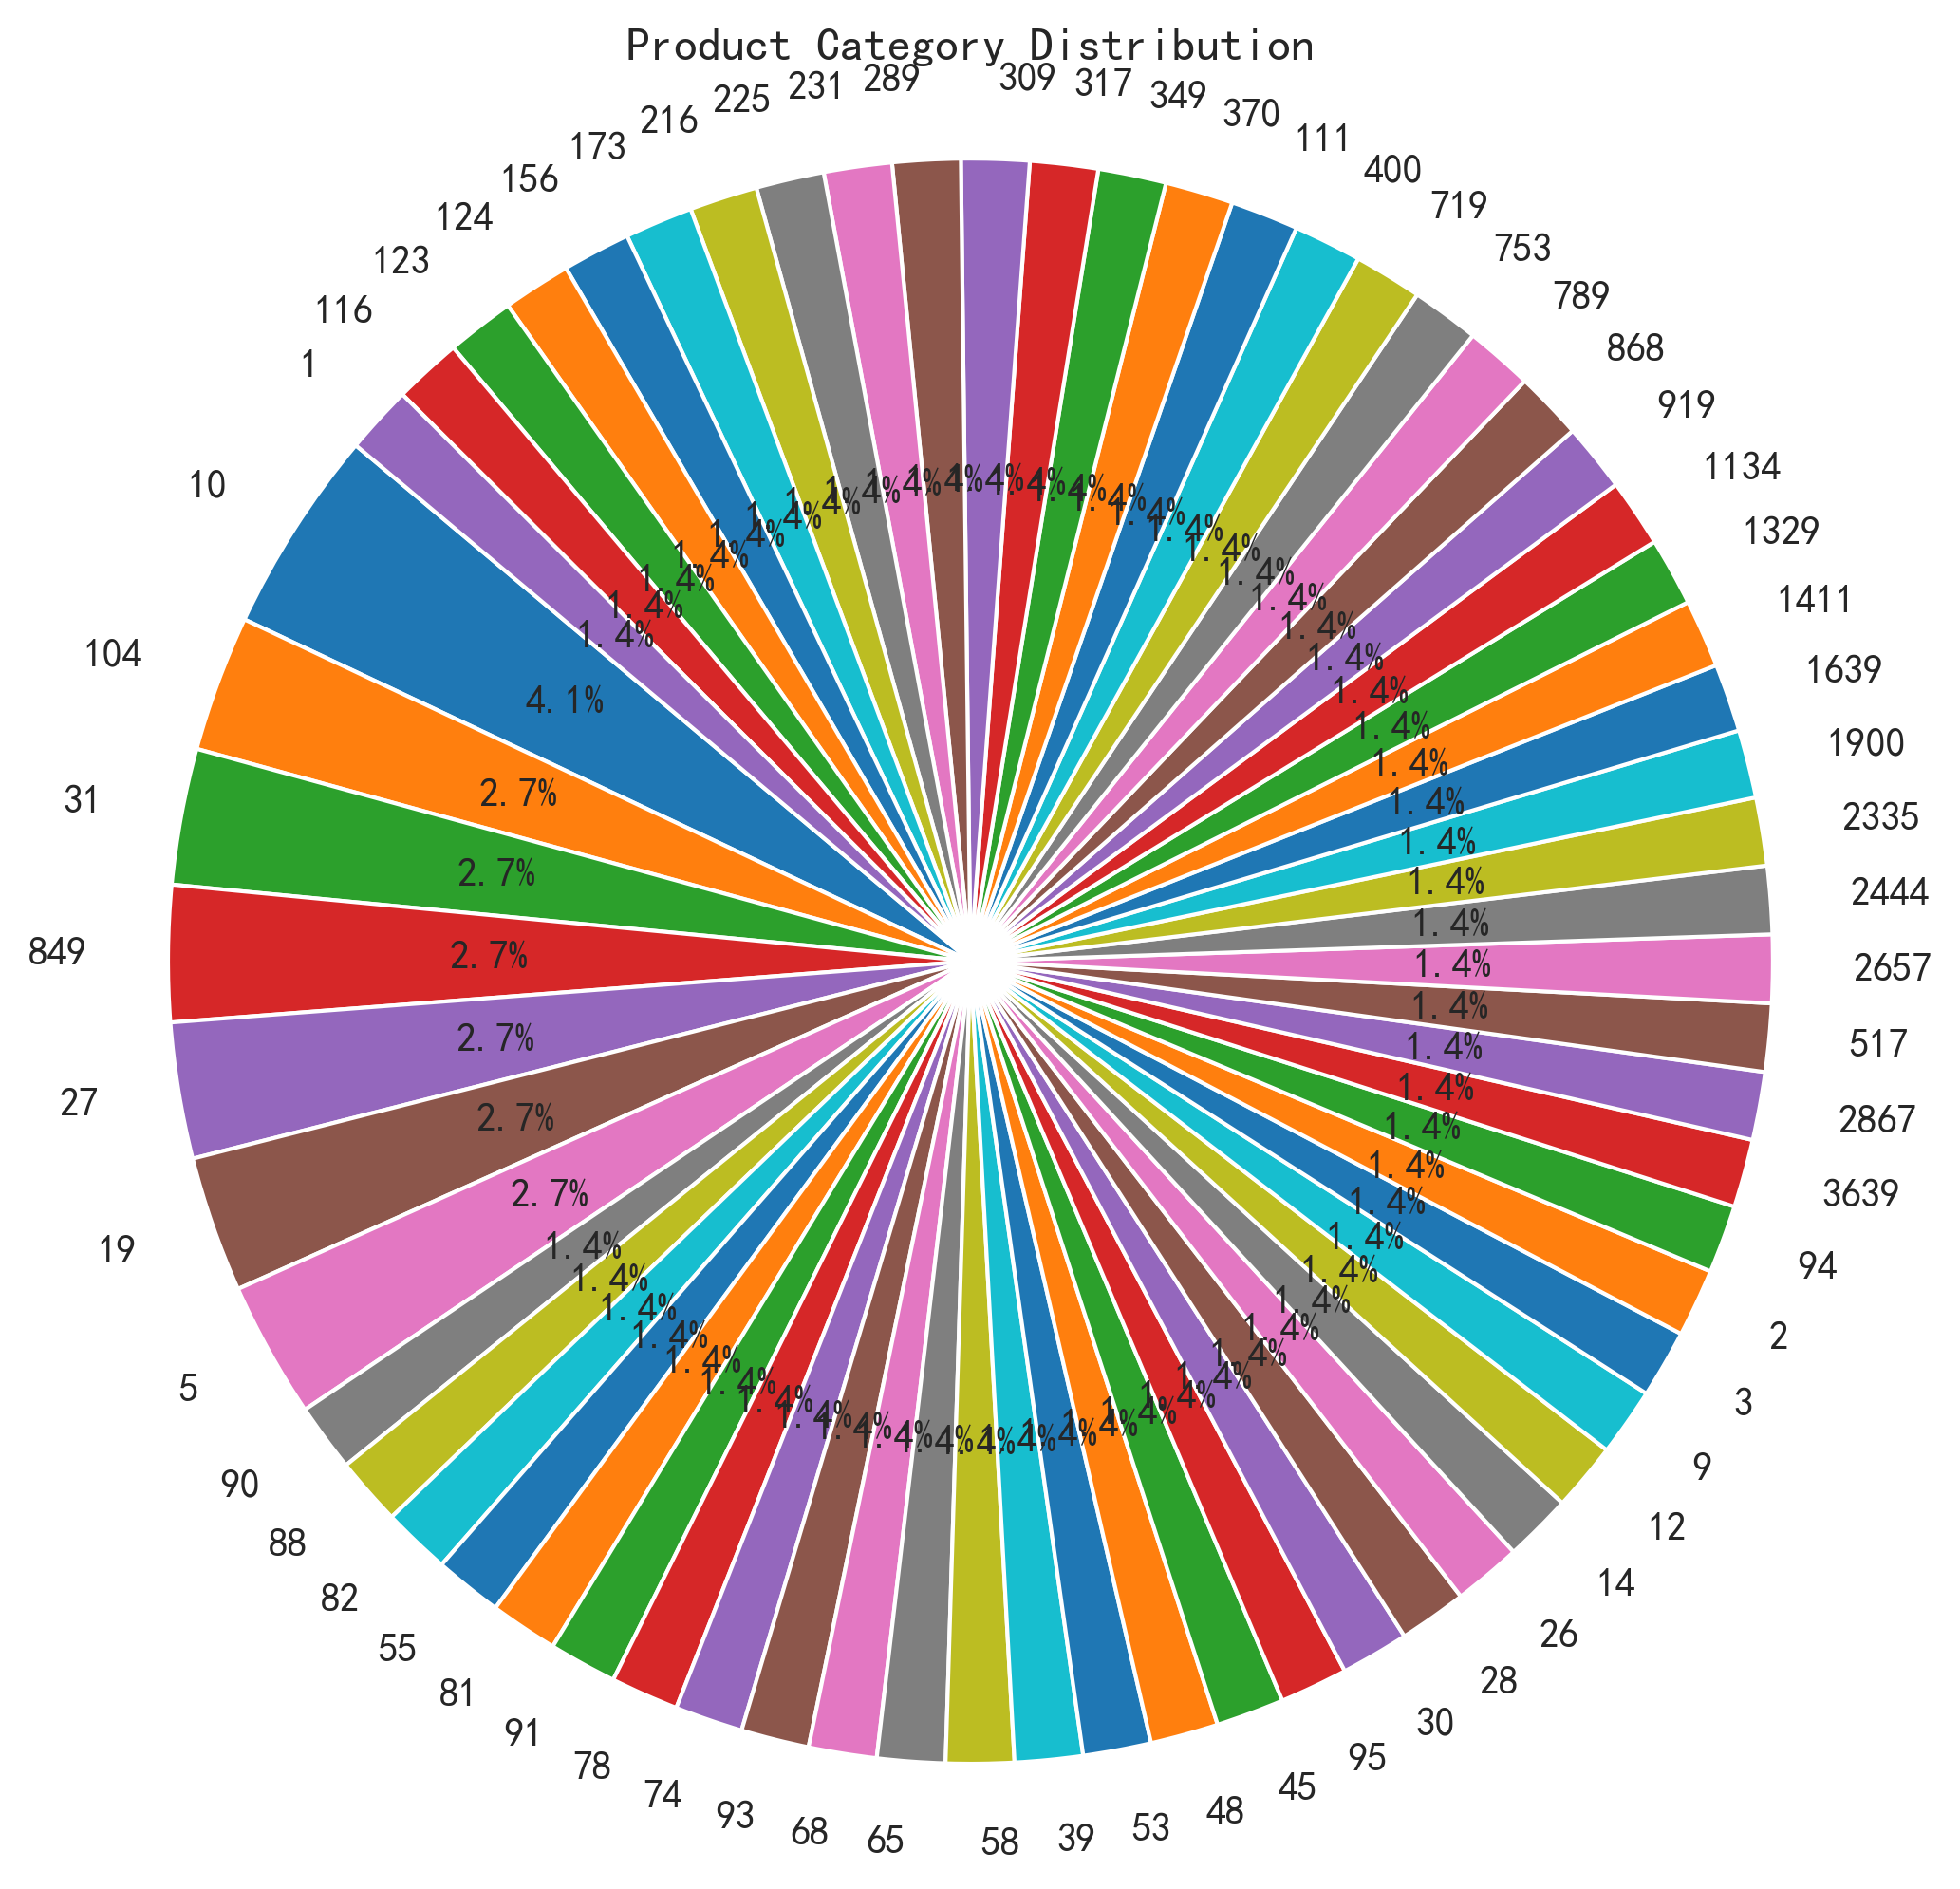

The quantity of different product categories:
 cama_mesa_banho                  3639
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 73, dtype: int64


In [59]:
# Count the quantity of different product categories
category_distribution = products['product_category_name'].value_counts()
# Calculate the total number of product categories
total_categories = len(category_distribution)
# Call a function to draw a pie chart
plot_pie_chart(category_distribution, title="Product Category Distribution")
# Print the quantity of different product categories
print('The quantity of different product categories:\n', category_distribution)


In [60]:
# Save the processed data as a CSV file
csv_path = r'D:\桌面\project\data\clean\products.csv'
products.to_csv(csv_path, index=False)

print(f'The processed data has been saved to:{csv_path}')

The processed data has been saved to:D:\桌面\project\data\clean\products.csv


## Observations on the product information table(olist_products_dataset.csv):
- Upon inspection, it was found that there are no duplicate values, but missing values exist. To address the missing values: fill the missing values of categorical variables with the mode, and fill the missing values of numerical variables (such as size and weight) with the mean. Finally, all fields are free of missing values.
- At the same time, a total of 73 product categories were counted, and the category distribution was visualized through a pie chart.

# User rating data

Handle missing values and duplicate values

In [61]:
# Detect missing values
missing_values = order_reviews.isnull().sum()

# Check the proportion of missing values
missing_value_percentage = (missing_values / len(order_reviews)) * 100

print('The number of missing values:\n', missing_values)
print('Proportion of missing values:\n', missing_value_percentage)

The number of missing values:
 review_id       0
order_id        0
review_score    0
dtype: int64
Proportion of missing values:
 review_id       0.0
order_id        0.0
review_score    0.0
dtype: float64


There are no missing values or duplicate values

## Key indicator statistics

In [62]:
# Check the rating column and its value distribution
score_counts = order_reviews['review_score'].value_counts(normalize=True).sort_index() * 100
score_counts = score_counts.round(2).reset_index()
score_counts.columns = ['review_score', 'percentage (%)']
score_counts

,review_score,percentage (%)
0,1,11.51
1,2,3.18
2,3,8.24
3,4,19.29
4,5,57.78


## Observations on the user rating table(olist_order_reviews_dataset.csv)：
 - Analysis shows no missing values or duplicate values. 
  - By counting the proportion of scores, it is found that 5 points account for 57.78%, 4 points account for 19.29%, 3 points account for 8.24%, 2 points account for 2.18%, and 1 point accounts for 11.51%. The data has an imbalance issue, which will be focused on addressing during subsequent modeling.